In [73]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month
from pyspark.sql.functions import col, rand
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import BucketedRandomProjectionLSH
import pyspark.sql.functions as F
import random
import os
import shutil
from pyspark.sql.functions import col, regexp_extract
spark = SparkSession.builder \
    .appName("SplitByYearMonth") \
    .getOrCreate()

In [74]:
df_new = spark.read.option("header", True).csv(
    "/storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv"
)


In [75]:
df_new.show(5)

+------+--------------------+-------------+-------------------+---------+-------+----------+--------------------+--------------+----+----+----+----+----+
|origen|                date|     username|      user_fullname|n_replies|n_likes|n_retweets|                text|tweet_language| _c9|_c10|_c11|_c12|_c13|
+------+--------------------+-------------+-------------------+---------+-------+----------+--------------------+--------------+----+----+----+----+----+
|   df1|2019-05-27 11:49:...|    bitcointe|          Bitcointe|        0|      0|         0|Cardano: Digitize...|            en|NULL|NULL|NULL|NULL|NULL|
|   df1|2019-05-27 11:49:...|    3eyedbran|Bran - 3 Eyed Raven|        0|      2|         1|Another Test twee...|            en|NULL|NULL|NULL|NULL|NULL|
|   df1|2019-05-27 11:49:...|DetroitCrypto|        J. Scardina|        0|      0|         0|Current Crypto Pr...|            en|NULL|NULL|NULL|NULL|NULL|
|   df1|2019-05-27 11:49:...| mmursaleen72| Muhammad Mursaleen|        0|   

25/12/03 16:54:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv


In [76]:
df_setiment = df_new

In [77]:
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [78]:
df_setiment = df_setiment.withColumn(
    "clean_text",
    lower(regexp_replace("text", "[^a-zA-Z0-9 ]", ""))
)

In [79]:
#Making a label column

In [82]:
df_setiment = df_setiment.withColumn(
    "label",
    when(col("clean_text").rlike("good|great|love|awesome|fantastic"), 1)
    .when(col("clean_text").rlike("bad|terrible|hate|awful|worst"), 0)
    .otherwise(2)     # neutral class instead of NULL
)

In [84]:
from pyspark.sql.functions import col

# Count how many rows are assigned to each label
label_counts = df_setiment.groupBy("label").count()

# Show the results
label_counts.show()


+-----+-----+
|label|count|
+-----+-----+
|    1|   20|
|    2|  283|
|    0|    4|
+-----+-----+



In [35]:
df_setiment = df_setiment.filter(col("clean_text").isNotNull())

In [36]:
train, test = df_setiment.randomSplit([0.8, 0.2], seed=1234)

In [37]:
#Pipeline

In [38]:
#Use tokenizer to remove whitespace
tokens = Tokenizer(inputCol="clean_text", outputCol="tokens")
sw = StopWordsRemover(inputCol="tokens", outputCol="clean_tokens")
tf = HashingTF(inputCol="clean_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")



In [39]:
pipeline = Pipeline(stages=[tokens, sw, tf, idf, lr])
model = pipeline.fit(train)

25/12/03 16:39:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv
25/12/03 16:39:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/12/03 16:39:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv
25/12/03 16:39:51 WARN DAGScheduler: Broadcast

In [26]:
pred = model.transform(test)
pred.select("text", "label", "prediction").show(20, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|text                                                                                                                                                                                                                                                                                                            |label|prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|The first lab made diamond 

25/12/03 16:38:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/12/03 16:38:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv


In [27]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")

accuracy = evaluator.evaluate(pred)
print("Accuracy =", accuracy)

Accuracy = 0.9444444444444444


25/12/03 16:38:12 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/12/03 16:38:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, , , , , 
 Schema: origen, date, username, user_fullname, n_replies, n_likes, n_retweets, text, tweet_language, _c9, _c10, _c11, _c12, _c13
Expected: _c9 but found: 
CSV file: file:///storage/work/eml6069/DS410/DS410_Final/sorted_output/results.csv


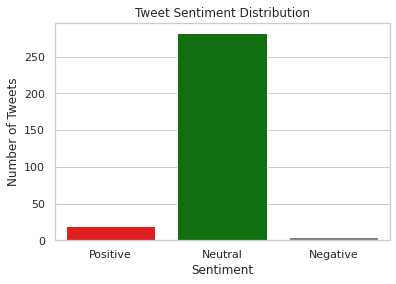

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate counts in PySpark
label_counts = df_setiment.groupBy("label").count().collect()

# 2. Convert to Pandas DataFrame
pdf = pd.DataFrame(label_counts, columns=["label", "count"])

# Optional: map labels to strings
label_map = {0: "Negative", 1: "Positive", 2: "Neutral"}
pdf["label_name"] = pdf["label"].map(label_map)

# 3. Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.barplot(x="label_name", y="count", data=pdf, palette=["red","green","gray"])
plt.title("Tweet Sentiment Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.show()
